#### Importing Libraries

In [1]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1

  # verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0rc1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0rc1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None


     |████████████████████████████████| 378kB 4.0MB/s 
     |████████████████████████████████| 235kB 22.3MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

#### Data Loading

In [3]:
keyword_links=pd.read_csv('/content/stack_network_links.csv')
keyword_links=keyword_links.drop(columns="value")
keyword_links

,source,target
0,azure,.net
1,sql-server,.net
2,asp.net,.net
3,entity-framework,.net
4,wpf,.net
...,...,...
485,objective-c,xcode
486,swift,xcode
487,iphone,xcode
488,ios,xcode


In [4]:
keyword_features=pd.read_csv('/content/stack_network_nodes.csv')
keyword_features=keyword_features.drop(columns="nodesize")
keyword_features=keyword_features.set_index("name")

keyword_group_raw=keyword_features
keyword_group_raw

,group
name,
html,6
css,6
hibernate,8
spring,8
ruby,3
...,...
perl,13
cloud,9
photoshop,6


In [5]:
#Entering node features as One-hot encoding
keyword_features=pd.get_dummies(keyword_features,columns=["group"])
keyword_group=keyword_features
keyword_group

,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,group_11,group_12,group_13,group_14
name,,,,,,,,,,,,,,
html,0,0,0,0,0,1,0,0,0,0,0,0,0,0
css,0,0,0,0,0,1,0,0,0,0,0,0,0,0
hibernate,0,0,0,0,0,0,0,1,0,0,0,0,0,0
spring,0,0,0,0,0,0,0,1,0,0,0,0,0,0
ruby,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
perl,0,0,0,0,0,0,0,0,0,0,0,0,1,0
cloud,0,0,0,0,0,0,0,0,1,0,0,0,0,0
photoshop,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Graph creation using StellerGraph

In [6]:
from stellargraph import StellarGraph

In [7]:
keyword_features= StellarGraph({"source": keyword_features}, {"target": keyword_links})
print(keyword_features.info())

StellarGraph: Undirected multigraph
 Nodes: 115, Edges: 490

 Node types:
  source: [115]
    Features: float32 vector, length 14
    Edge types: source-target->source

 Edge types:
    source-target->source: [490]
        Weights: all 1 (default)


#### Embedding generation using GraphSAGE

In [10]:
#Unsupervised GraphSAGE implementation starts here

nodes = list(keyword_features.nodes())
number_of_walks = 1
length = 3

unsupervised_samples = UnsupervisedSampler(
    keyword_features, nodes=nodes, length=length, number_of_walks=number_of_walks
)
batch_size = 20
epochs = 4
num_samples = [5, 3]

generator = GraphSAGELinkGenerator(keyword_features, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

layer_sizes = [15, 15]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [13]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

In [14]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
#Model Training
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/4
23/23 [==============================] - 2s 8ms/step - loss: 0.6774 - binary_accuracy: 0.5087
Epoch 2/4
23/23 [==============================] - 0s 9ms/step - loss: 0.5957 - binary_accuracy: 0.6152
Epoch 3/4
23/23 [==============================] - 0s 11ms/step - loss: 0.5807 - binary_accuracy: 0.7022
Epoch 4/4
23/23 [==============================] - 0s 10ms/step - loss: 0.5519 - binary_accuracy: 0.7391


In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [19]:
node_ids = keyword_group.index
node_gen = GraphSAGENodeGenerator(keyword_features, batch_size, num_samples).flow(node_ids)

In [20]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

6/6 [==============================] - 0s 15ms/step


In [22]:
node_embeddings.shape

(115, 15)

#### Clustering using embedding

In [ ]:
!pip install hdbscan
import hdbscan

In [32]:
cluster = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric='euclidean', cluster_selection_method='eom').fit(node_embeddings)
res = list(zip(list(keyword_group.index),cluster.labels_))
cluster.labels_

array([ 3,  3,  5,  5,  1,  1,  6,  6,  3,  2,  2,  4,  4,  6,  3,  3,  1,
        1,  3,  3,  5,  4,  1,  5,  3,  3, -1, -1,  4,  1,  1,  1,  6,  7,
        7, -1, -1,  4,  4,  4,  4,  6,  5, -1,  3,  2,  2, -1,  6,  7,  7,
       -1,  3,  3,  4,  4,  3,  3,  2,  3,  5,  5,  5,  7,  7,  2,  2,  3,
       -1, -1,  3,  5,  5, -1, -1,  6,  1, -1,  0,  0,  2,  7,  2,  2,  7,
        7,  3,  1,  3,  2,  2,  0,  4,  1,  4,  7,  5,  4,  4,  0,  3,  7,
        3,  4,  4,  4, -1,  5,  3,  4,  4,  0,  3,  7,  2])

In [34]:
cluster_dict = {}
for i in range(-1,8):
  l = []
  for each in res:
    if each[1]==i:
      l.append(each[0])
  cluster_dict[i] = l
cluster_dict

{-1: ['hadoop',
  'apache-spark',
  'excel',
  'excel-vba',
  'scala',
  'vba',
  'angularjs',
  'tdd',
  'agile',
  'testing',
  'selenium',
  'jenkins',
  'haskell'],
 0: ['docker', 'amazon-web-services', 'go', 'devops', 'cloud'],
 1: ['ruby',
  'ruby-on-rails',
  'redux',
  'reactjs',
  'react-native',
  'express',
  'node.js',
  'mongodb',
  'redis',
  'elasticsearch',
  'postgresql'],
 2: ['c',
  'c++',
  'django',
  'python',
  'flask',
  'angular2',
  'typescript',
  'angular',
  'machine-learning',
  'qt',
  'r',
  'embedded',
  'matlab'],
 3: ['html',
  'css',
  'html5',
  'javascript',
  'jquery',
  'php',
  'mysql',
  'less',
  'sass',
  'ajax',
  'asp.net-web-api',
  'laravel',
  'json',
  'xml',
  'wordpress',
  'codeigniter',
  'twitter-bootstrap',
  'ionic-framework',
  'vue.js',
  'drupal',
  'bootstrap',
  'twitter-bootstrap-3',
  'photoshop'],
 4: ['asp.net',
  'c#',
  '.net',
  'sql-server',
  'entity-framework',
  'linq',
  'wcf',
  'wpf',
  'plsql',
  'oracle',
  '

#### Visualization [Dimension reduction using PCA]

In [35]:
X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed["label"] = keyword_group_raw
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = keyword_group_raw

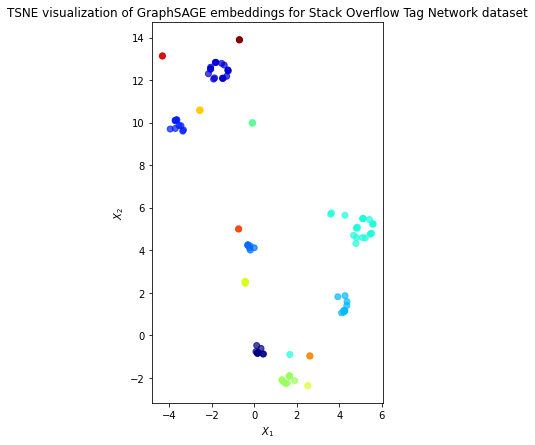

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for Stack Overflow Tag Network dataset".format(transform.__name__)
)
plt.show()